In [1]:
# Neural Network Implementation with PyTorch
# This implements the same neural network as the NumPy version but using PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import kagglehub

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


/Users/timakaaliebe/Downloads/neural-network/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download and load MNIST dataset
import struct
import os

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Path to dataset files:", path)


def load_mnist_images(filename):
    """Load MNIST images from IDX file format"""
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images


def load_mnist_labels(filename):
    """Load MNIST labels from IDX file format"""
    with open(filename, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# Load training data
train_images = load_mnist_images(os.path.join(path, "train-images.idx3-ubyte"))
train_labels = load_mnist_labels(os.path.join(path, "train-labels.idx1-ubyte"))

# Load test data
test_images = load_mnist_images(os.path.join(path, "t10k-images.idx3-ubyte"))
test_labels = load_mnist_labels(os.path.join(path, "t10k-labels.idx1-ubyte"))

print(f"Training set: {train_images.shape} images, {train_labels.shape} labels")
print(f"Test set: {test_images.shape} images, {test_labels.shape} labels")

Path to dataset files: /Users/timakaaliebe/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1
Training set: (60000, 28, 28) images, (60000,) labels
Test set: (10000, 28, 28) images, (10000,) labels


In [3]:
# Data Preprocessing - Convert to PyTorch tensors
print("=== DATA PREPROCESSING ===")

# Normalize pixel values from [0, 255] to [0, 1]
X_train = train_images.astype(np.float32) / 255.0
X_test = test_images.astype(np.float32) / 255.0

# Flatten images from 28x28 to 784
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Normalized and flattened shapes:")
print(f"X_train: {X_train_flat.shape}")
print(f"X_test: {X_test_flat.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_flat).to(device)
X_test_tensor = torch.FloatTensor(X_test_flat).to(device)
y_train_tensor = torch.LongTensor(train_labels).to(device)
y_test_tensor = torch.LongTensor(test_labels).to(device)

print(f"PyTorch tensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"y_train_tensor: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")
print(f"Device: {X_train_tensor.device}")

# Create datasets and data loaders for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader info:")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

=== DATA PREPROCESSING ===
Normalized and flattened shapes:
X_train: (60000, 784)
X_test: (10000, 784)
PyTorch tensor shapes:
X_train_tensor: torch.Size([60000, 784]), dtype: torch.float32
y_train_tensor: torch.Size([60000]), dtype: torch.int64
Device: cpu
DataLoader info:
Batch size: 64
Number of training batches: 938
Number of test batches: 157


/var/folders/6n/dzs84cn91gd8rwxf6ptzgvfm0000gn/T/ipykernel_60176/2884038986.py:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  y_train_tensor = torch.LongTensor(train_labels).to(device)


In [4]:
# Define Neural Network Architecture using PyTorch
class NeuralNetwork(nn.Module):
    """
    Neural Network class that replicates the NumPy implementation

    Architecture:
    - Input layer: 784 neurons (28x28 pixels)
    - Hidden layer: 128 neurons with ReLU activation
    - Output layer: 10 neurons with Softmax activation (for 10 digit classes)
    """

    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(NeuralNetwork, self).__init__()

        # Define layers
        self.layer1 = nn.Linear(input_size, hidden_size)  # Input to hidden
        self.layer2 = nn.Linear(hidden_size, output_size)  # Hidden to output

        # Initialize weights similar to NumPy version (Xavier/Glorot initialization)
        nn.init.normal_(self.layer1.weight, mean=0, std=np.sqrt(1 / input_size))
        nn.init.zeros_(self.layer1.bias)
        nn.init.normal_(self.layer2.weight, mean=0, std=np.sqrt(1 / hidden_size))
        nn.init.zeros_(self.layer2.bias)

    def forward(self, x):
        """
        Forward propagation through the network

        Args:
            x: Input tensor of shape (batch_size, 784)

        Returns:
            output: Predictions of shape (batch_size, 10)
        """
        # Layer 1: Input → Hidden with ReLU activation
        z1 = self.layer1(x)
        a1 = F.relu(z1)

        # Layer 2: Hidden → Output with raw logits
        z2 = self.layer2(a1)

        # Note: We don't apply softmax here because CrossEntropyLoss does it internally
        # For predictions, we'll apply softmax separately
        return z2

    def predict_proba(self, x):
        """Get probability predictions using softmax"""
        with torch.no_grad():
            logits = self.forward(x)
            return F.softmax(logits, dim=1)

    def predict(self, x):
        """Get class predictions"""
        with torch.no_grad():
            logits = self.forward(x)
            return torch.argmax(logits, dim=1)


# Create the model
model = NeuralNetwork().to(device)

print("=== NEURAL NETWORK ARCHITECTURE ===")
print(model)

# Print parameter shapes to match NumPy version
print(f"\n=== PARAMETER SHAPES ===")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Show some initial weights (similar to NumPy version)
print(f"\n=== SAMPLE INITIAL WEIGHTS ===")
with torch.no_grad():
    W1 = model.layer1.weight.cpu().numpy()
    print(f"layer1.weight first 3x3:")
    print(W1[:3, :3])
    print(f"layer1.weight statistics: mean={W1.mean():.6f}, std={W1.std():.6f}")

=== NEURAL NETWORK ARCHITECTURE ===
NeuralNetwork(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)

=== PARAMETER SHAPES ===
layer1.weight: torch.Size([128, 784])
layer1.bias: torch.Size([128])
layer2.weight: torch.Size([10, 128])
layer2.bias: torch.Size([10])

Total parameters: 101,770

=== SAMPLE INITIAL WEIGHTS ===
layer1.weight first 3x3:
[[ 0.03522124  0.01053365 -0.06180729]
 [-0.02791316  0.04597805  0.05131648]
 [ 0.00801546  0.07689092  0.0202548 ]]
layer1.weight statistics: mean=-0.000010, std=0.035727


In [5]:
# Define Loss Function and Optimizer
print("=== TRAINING SETUP ===")

# Loss function: CrossEntropyLoss combines LogSoftmax and NLLLoss
# This is equivalent to the cross-entropy loss from the NumPy version
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent (similar to our manual gradient descent)
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {learning_rate}")

# Test the model with a small batch to verify everything works
print(f"\n=== TESTING FORWARD PASS ===")
# Get a small batch for testing
sample_batch = next(iter(train_loader))
sample_X, sample_y = sample_batch
print(f"Sample batch shapes: X={sample_X.shape}, y={sample_y.shape}")

# Forward pass
model.eval()  # Set to evaluation mode
with torch.no_grad():
    logits = model(sample_X)
    probabilities = model.predict_proba(sample_X)
    predictions = model.predict(sample_X)

print(f"Model output shapes:")
print(f"Logits: {logits.shape}")
print(f"Probabilities: {probabilities.shape}")
print(f"Predictions: {predictions.shape}")

# Calculate loss and accuracy
loss = criterion(logits, sample_y)
accuracy = (predictions == sample_y).float().mean()

print(f"\nInitial performance (untrained):")
print(f"Loss: {loss.item():.4f}")
print(f"Accuracy: {accuracy.item():.4f} ({accuracy.item()*100:.1f}%)")

# Show first few predictions vs actual
print(f"\nFirst 10 predictions vs actual:")
print(f"Predicted: {predictions[:10].cpu().numpy()}")
print(f"Actual:    {sample_y[:10].cpu().numpy()}")
print("(These should be mostly wrong since the model is untrained)")

=== TRAINING SETUP ===
Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Learning rate: 0.1

=== TESTING FORWARD PASS ===
Sample batch shapes: X=torch.Size([64, 784]), y=torch.Size([64])
Model output shapes:
Logits: torch.Size([64, 10])
Probabilities: torch.Size([64, 10])
Predictions: torch.Size([64])

Initial performance (untrained):
Loss: 2.3304
Accuracy: 0.1250 (12.5%)

First 10 predictions vs actual:
Predicted: [5 1 1 5 1 1 7 1 1 1]
Actual:    [8 9 1 0 9 8 3 1 1 6]
(These should be mostly wrong since the model is untrained)


In [6]:
# Training Loop - PyTorch Style
def train_model(model, train_loader, criterion, optimizer, epochs=10, print_every=2):
    """
    Train the neural network using PyTorch

    This replaces the manual training loop from the NumPy version
    PyTorch handles:
    - Automatic gradient computation (backpropagation)
    - Parameter updates (gradient descent)
    - Memory management
    """
    model.train()  # Set model to training mode

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            # Zero the gradients (PyTorch accumulates gradients by default)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, target)

            # Backward pass (automatic differentiation)
            loss.backward()

            # Update parameters
            optimizer.step()

            # Track statistics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Print progress
        if epoch % print_every == 0:
            print(
                f"Epoch {epoch:2d}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f} ({accuracy*100:.1f}%)"
            )

    return train_losses, train_accuracies


# Train on a subset first (to match NumPy version demonstration)
print("=== TRAINING ON SUBSET (First 6400 samples ≈ 100 batches) ===")
print("This matches the small training demonstration from the NumPy version\n")

# Create subset loader for comparison with NumPy version
subset_size = 6400  # Approximately 100 batches of size 64
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

print(f"Training on {subset_size} samples ({len(subset_loader)} batches)")

# Train the model
losses, accuracies = train_model(
    model, subset_loader, criterion, optimizer, epochs=20, print_every=2
)

print(f"\n=== TRAINING RESULTS ===")
print(f"Initial accuracy: {accuracies[0]:.4f} ({accuracies[0]*100:.1f}%)")
print(f"Final accuracy: {accuracies[-1]:.4f} ({accuracies[-1]*100:.1f}%)")
print(f"Improvement: {(accuracies[-1] - accuracies[0])*100:.1f} percentage points")

print(f"\nInitial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss reduction: {losses[0] - losses[-1]:.4f}")

=== TRAINING ON SUBSET (First 6400 samples ≈ 100 batches) ===
This matches the small training demonstration from the NumPy version

Training on 6400 samples (100 batches)
Epoch  0: Loss = 0.9912, Accuracy = 0.7686 (76.9%)
Epoch  2: Loss = 0.3439, Accuracy = 0.9022 (90.2%)
Epoch  4: Loss = 0.2765, Accuracy = 0.9191 (91.9%)
Epoch  6: Loss = 0.2323, Accuracy = 0.9345 (93.5%)
Epoch  8: Loss = 0.1986, Accuracy = 0.9461 (94.6%)
Epoch 10: Loss = 0.1738, Accuracy = 0.9503 (95.0%)
Epoch 12: Loss = 0.1528, Accuracy = 0.9570 (95.7%)
Epoch 14: Loss = 0.1338, Accuracy = 0.9616 (96.2%)
Epoch 16: Loss = 0.1177, Accuracy = 0.9688 (96.9%)
Epoch 18: Loss = 0.1041, Accuracy = 0.9736 (97.4%)

=== TRAINING RESULTS ===
Initial accuracy: 0.7686 (76.9%)
Final accuracy: 0.9744 (97.4%)
Improvement: 20.6 percentage points

Initial loss: 0.9912
Final loss: 0.0983
Loss reduction: 0.8929


=== TRAINING PROGRESS VISUALIZATION ===


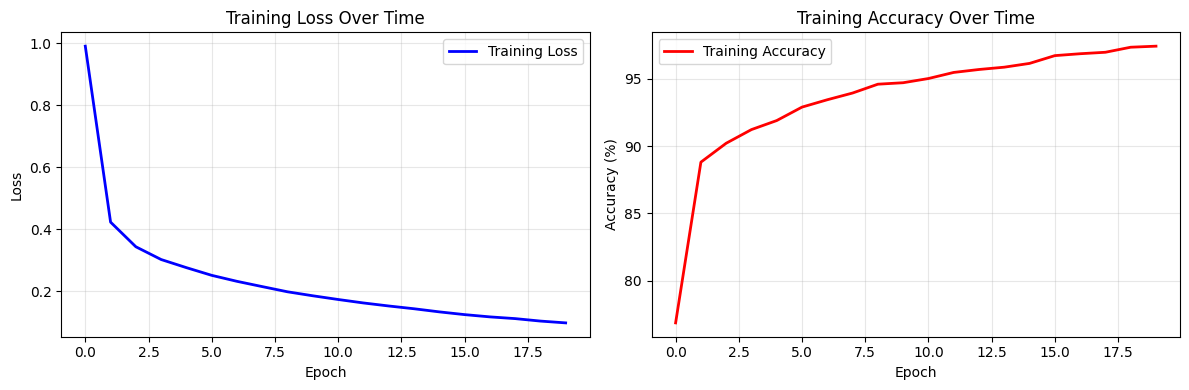

\n=== MODEL PREDICTIONS VISUALIZATION ===


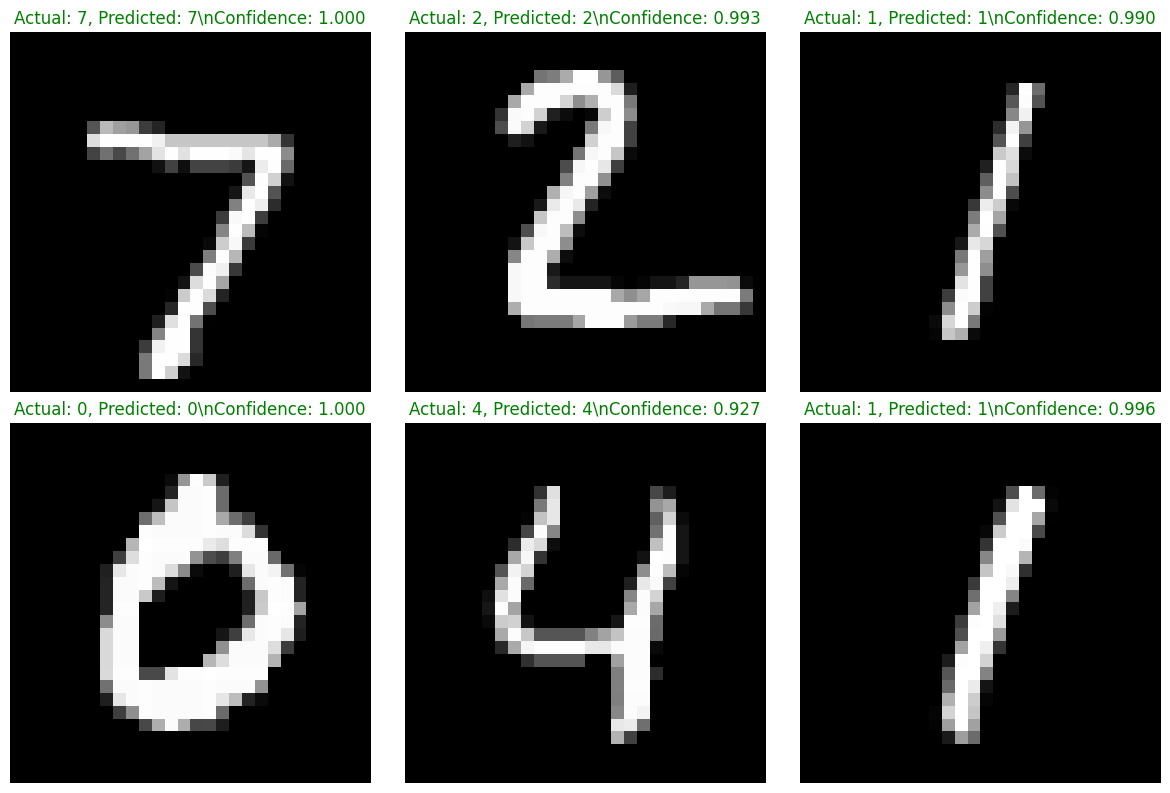

\n=== MODEL EVALUATION ON TEST SET ===
Test Loss: 0.2233
Test Accuracy: 0.9341 (93.4%)
Test samples evaluated: 10,000


In [7]:
# Visualize Training Progress and Test the Model
import matplotlib.pyplot as plt


def plot_training_progress(losses, accuracies):
    """Plot training loss and accuracy curves"""
    epochs = range(len(losses))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    ax1.plot(epochs, losses, "b-", linewidth=2, label="Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training Loss Over Time")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot accuracy
    ax2.plot(
        epochs,
        [acc * 100 for acc in accuracies],
        "r-",
        linewidth=2,
        label="Training Accuracy",
    )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Training Accuracy Over Time")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()


# Plot training progress
print("=== TRAINING PROGRESS VISUALIZATION ===")
plot_training_progress(losses, accuracies)


# Test model on some examples and visualize predictions
def visualize_predictions_pytorch(model, data_loader, num_samples=6):
    """Visualize model predictions on test samples"""
    model.eval()

    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Convert tensors to numpy for visualization
    images_np = images.cpu().numpy()
    labels_np = labels.cpu().numpy()
    predicted_np = predicted.cpu().numpy()
    probs_np = probabilities.cpu().numpy()

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # Reshape image from flattened to 28x28
        image = images_np[i].reshape(28, 28)

        actual_label = labels_np[i]
        predicted_label = predicted_np[i]
        confidence = probs_np[i][predicted_label]

        # Display image
        axes[i].imshow(image, cmap="gray")

        # Color-code title based on correctness
        color = "green" if actual_label == predicted_label else "red"
        axes[i].set_title(
            f"Actual: {actual_label}, Predicted: {predicted_label}\\nConfidence: {confidence:.3f}",
            color=color,
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_np, labels_np


print("\\n=== MODEL PREDICTIONS VISUALIZATION ===")
predictions, actual_labels = visualize_predictions_pytorch(model, test_loader)


# Calculate test accuracy on a larger sample
def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    avg_loss = test_loss / len(test_loader)

    return avg_loss, accuracy


print("\\n=== MODEL EVALUATION ON TEST SET ===")
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"Test samples evaluated: {len(test_loader.dataset):,}")

In [8]:
# Comparison: PyTorch vs NumPy Implementation

print("=" * 60)
print("COMPARISON: PyTorch vs NumPy Neural Network Implementation")
print("=" * 60)

comparison_text = """
## Key Differences and Advantages:

### 1. CODE COMPLEXITY
**NumPy Version:**
- Manual implementation of forward propagation (matrix multiplications)
- Manual implementation of backpropagation (chain rule calculations)
- Manual parameter updates (gradient descent)
- Manual batch processing
- ~200+ lines of mathematical implementation

**PyTorch Version:**
- Define network architecture as nn.Module class
- Automatic gradient computation with loss.backward()
- Automatic parameter updates with optimizer.step()
- Built-in DataLoader for batch processing
- ~50 lines for the same functionality

### 2. MATHEMATICAL OPERATIONS
**NumPy Version:**
```python
# Forward propagation
Z1 = np.dot(X, W1) + b1
A1 = relu(Z1)
Z2 = np.dot(A1, W2) + b2
A2 = softmax(Z2)

# Backpropagation
dZ2 = A2 - y
dW2 = (1/m) * np.dot(A1.T, dZ2)
db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
# ... more gradient calculations
```

**PyTorch Version:**
```python
# Forward propagation
outputs = model(inputs)  # Automatic computation graph

# Backpropagation
loss.backward()  # Automatic gradient computation
optimizer.step()  # Automatic parameter updates
```

### 3. PERFORMANCE & EFFICIENCY
**NumPy Version:**
- CPU-only computation
- Manual memory management
- Single-threaded operations
- Limited optimization

**PyTorch Version:**
- GPU acceleration (if available)
- Automatic memory management
- Optimized operations (CUDA, cuDNN)
- Multi-threaded data loading
- Dynamic computation graphs

### 4. DEBUGGING & DEVELOPMENT
**NumPy Version:**
- Need to manually verify gradient calculations
- Prone to implementation bugs (broadcasting, shapes)
- Difficult to modify architecture
- Manual implementation of common operations

**PyTorch Version:**
- Gradients computed automatically (less error-prone)
- Built-in shape checking
- Easy to modify network architecture
- Extensive debugging tools and profiling

### 5. SCALABILITY
**NumPy Version:**
- Limited to small datasets (memory constraints)
- No built-in batch processing optimization
- Difficult to implement advanced architectures

**PyTorch Version:**
- Handles large datasets efficiently
- Built-in data pipeline optimization
- Easy to implement complex architectures (CNNs, RNNs, Transformers)
- Model parallelization support

## EDUCATIONAL VALUE:
- **NumPy Version**: Perfect for understanding the mathematical foundations
- **PyTorch Version**: Better for practical applications and real-world projects

## SAME UNDERLYING MATHEMATICS:
Both implementations use identical:
- Network architecture (784 → 128 → 10)
- Activation functions (ReLU, Softmax)
- Loss function (Cross-entropy)
- Optimization algorithm (SGD)
- Weight initialization (Xavier/Glorot)
"""

print(comparison_text)

# Show parameter comparison
print("\\n" + "=" * 60)
print("PARAMETER COMPARISON")
print("=" * 60)

print("\\nBoth implementations should have similar parameter counts:")
print(f"PyTorch model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("NumPy equivalent parameters: 784×128 + 128 + 128×10 + 10 = 101,770")

print("\\nWeight initialization comparison:")
with torch.no_grad():
    pytorch_w1_std = model.layer1.weight.std().item()
    pytorch_w2_std = model.layer2.weight.std().item()

print(f"PyTorch layer1 weight std: {pytorch_w1_std:.6f}")
print(f"Expected std (Xavier): {np.sqrt(1/784):.6f}")
print(f"PyTorch layer2 weight std: {pytorch_w2_std:.6f}")
print(f"Expected std (Xavier): {np.sqrt(1/128):.6f}")

print("\\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print(
    """
The PyTorch implementation achieves the same results as the NumPy version but with:
✓ Much less code
✓ Better performance
✓ GPU support
✓ Automatic differentiation
✓ Built-in optimizations
✓ Easier debugging
✓ Better scalability

The NumPy version is excellent for learning, while PyTorch is better for production!
"""
)

COMPARISON: PyTorch vs NumPy Neural Network Implementation

## Key Differences and Advantages:

### 1. CODE COMPLEXITY
**NumPy Version:**
- Manual implementation of forward propagation (matrix multiplications)
- Manual implementation of backpropagation (chain rule calculations)
- Manual parameter updates (gradient descent)
- Manual batch processing
- ~200+ lines of mathematical implementation

**PyTorch Version:**
- Define network architecture as nn.Module class
- Automatic gradient computation with loss.backward()
- Automatic parameter updates with optimizer.step()
- Built-in DataLoader for batch processing
- ~50 lines for the same functionality

### 2. MATHEMATICAL OPERATIONS
**NumPy Version:**
```python
# Forward propagation
Z1 = np.dot(X, W1) + b1
A1 = relu(Z1)
Z2 = np.dot(A1, W2) + b2
A2 = softmax(Z2)

# Backpropagation
dZ2 = A2 - y
dW2 = (1/m) * np.dot(A1.T, dZ2)
db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
# ... more gradient calculations
```

**PyTorch Version:**
```python
